# Analisis Karakteristik Data Audio
Source code ini digunakan untuk mengetahui karakteristik data audio dari dataset ArDad dengan 30 imam terkenal. Diharapkan dengan analisis ini dapat membantu dalam proses preprocessing data audio dan menjadi dasar untuk pengambilan keputusan terkait dengan fitur audio yang diambil. Kemudian perbandingan anatara penggunaan tensor vs librosa dala mengolah data audio.

### Import Library

In [4]:
import tensorflow as tf
import librosa
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt  
import os

2024-05-21 15:49:00.376822: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 15:49:00.377011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 15:49:00.443128: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 15:49:00.569450: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 15:49:01.993068: W tensorflow/compiler/tf2

## Function to Extract Audio Features

### Define Function General

In [5]:
def get_shape_and_dtype(audio):
    return audio.shape, audio.dtype

In [6]:
def plot_waveform(audio, sr, title):
    # plot the first audio file
    d = len(audio) / sr
    t = np.linspace(0, d, len(audio))
    plt.figure(figsize=(14, 5))
    plt.plot(t, audio)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Waveform of ' + title)

In [7]:
def plot_spectrogram(title, spectrogram, sr):
    # plot the spectrogram
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title(title)

### Define Librosa Function

In [8]:
def load_audio_lb(file):
    audio, sr = librosa.load(file)
    return audio, sr

In [9]:
def get_spectrogram_lb(audio, n_fft=2048, hop_length=512):
    spectrogram = np.abs(librosa.stft(audio, win_length=n_fft, hop_length=hop_length, n_fft=n_fft, center=False))    
    spectrogram = librosa.amplitude_to_db(spectrogram)
    return spectrogram

In [10]:
def get_mel_spectrogram_lb(audio,  sr, n_fft=2048, hop_length=512, n_mels=128):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, center=False)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram

### Define Tensor Function

In [11]:
def load_audio_tf(file):
    audio = tf.io.read_file(file)
    audio, sr = tf.audio.decode_wav(audio, desired_channels=1)
    audio = tf.squeeze(audio, axis=1)
    return audio, sr

In [12]:
def get_spectrogram_tf(audio, n_fft=2048, hop_length=512):
    # get the spectrogram
    spectrogram = tf.signal.stft(audio, frame_length=n_fft, frame_step=hop_length, fft_length=n_fft)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.transpose(spectrogram)
    spectrogram = 10 * tf.math.log(spectrogram + 1e-9)
    return spectrogram

In [13]:
def get_mel_spectrogram_tf(audio, sr, n_fft=2048, hop_length=512, n_mels=128):
    # plot the mel spectrogram using tensorflow
    spectrogram = tf.signal.stft(audio, frame_length=n_fft, frame_step=hop_length, fft_length=n_fft)
    spectrogram = tf.abs(spectrogram)    
    mel_filter = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=n_mels, 
        num_spectrogram_bins=spectrogram.shape[-1], 
        sample_rate=sr,
        lower_edge_hertz=20.0,
        upper_edge_hertz=sr/2.0
    )
    # mel_filter = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
    # mel_filter = tf.convert_to_tensor(mel_filter, dtype=tf.float32)
    # mel_filter = tf.transpose(mel_filter)
    mel_spectrogram = tf.tensordot(spectrogram, mel_filter, 1)
    mel_spectrogram = tf.transpose(mel_spectrogram)
    mel_spectrogram = 10 * tf.math.log(mel_spectrogram + 1e-9)
    return mel_spectrogram

## Analisis Data Audio


### Initial Setup

In [14]:
files = []

lb_audios = []
lb_srs = []
tf_audios = []
tf_srs = []

# iterate over all files in data folder
for file in os.listdir('test_data'):
    if file.endswith('.wav'):
        files.append(file)
files.sort()

for file in files:
    # load audio file with librosa
    lb_audio, lb_sr = load_audio_lb('test_data/' + file)
    lb_audios.append(lb_audio)
    lb_srs.append(lb_sr)

    # load audio file with tensorflow
    file = 'test_data/' + file
    tf_audio, tf_sr = load_audio_tf(file) 
    tf_audios.append(tf_audio)
    tf_srs.append(tf_sr)

2024-05-21 15:49:06.703413: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 15:49:07.177058: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 15:49:07.177293: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 15:49:07.182736: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 15:49:07.182821: I external/local_xla/xla/stream_executor

### Total Sample and Sample Rate

In [15]:
# Librosa
print("librosa audio : ", get_shape_and_dtype(lb_audios[1]), lb_srs[1])

# TensorFlow
print("tensor audio : ", get_shape_and_dtype(tf_audios[1]), tf_srs[1])

librosa audio :  ((84120,), dtype('float32')) 22050
tensor audio :  (TensorShape([168239]), tf.float32) tf.Tensor(44100, shape=(), dtype=int32)


### Play Sample Audio

In [16]:
ipd.Audio(lb_audios[2], rate=lb_srs[2])

In [17]:
ipd.Audio(tf_audios[2].numpy(), rate=tf_srs[2].numpy())

### Waveform

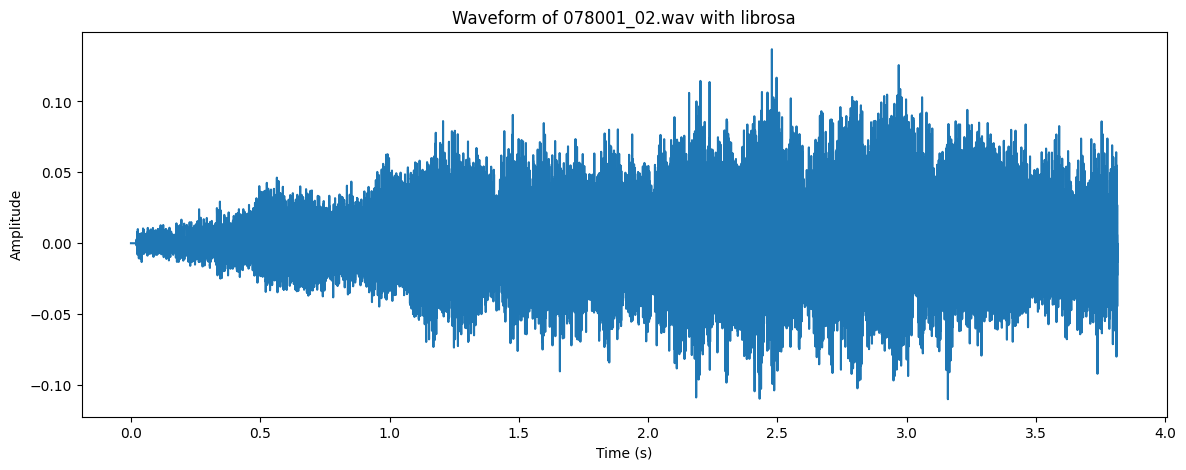

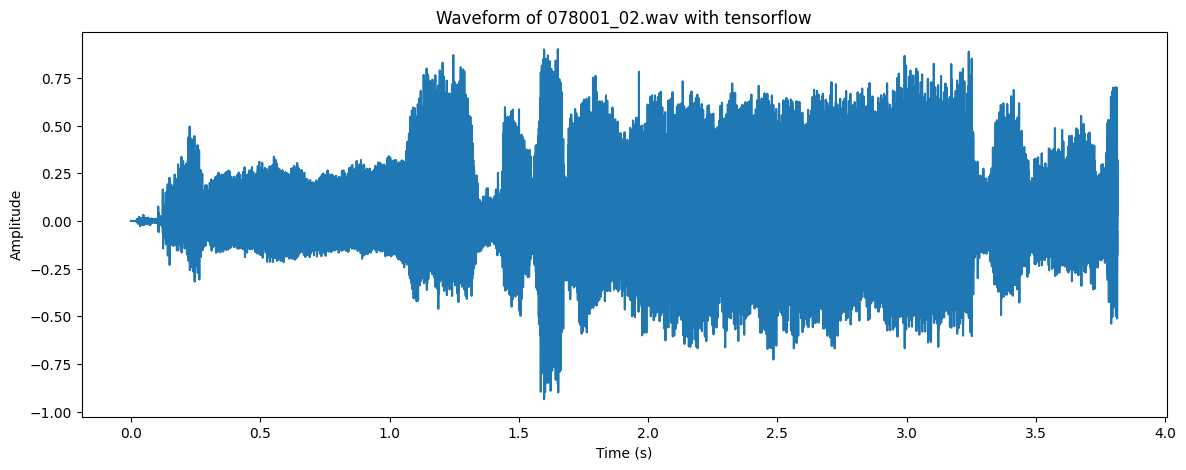

In [18]:
# plot the first audio file
plot_waveform(lb_audios[1], lb_srs[1], files[1]+" with librosa")
plot_waveform(tf_audios[1].numpy(), tf_srs[1].numpy(), files[1] + " with tensorflow")

### Spectogram

2024-05-21 15:49:13.723629: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


(1025, 161) float32
(1025, 325) <dtype: 'float32'>


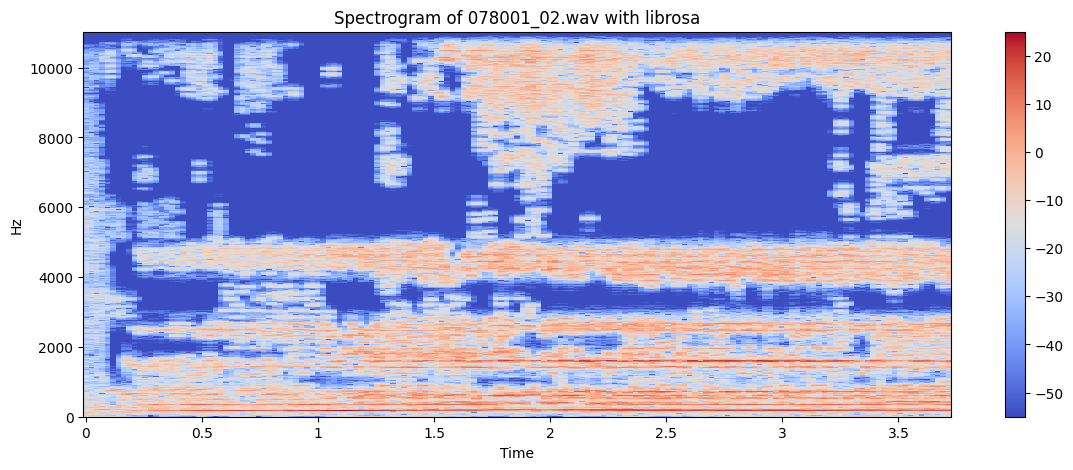

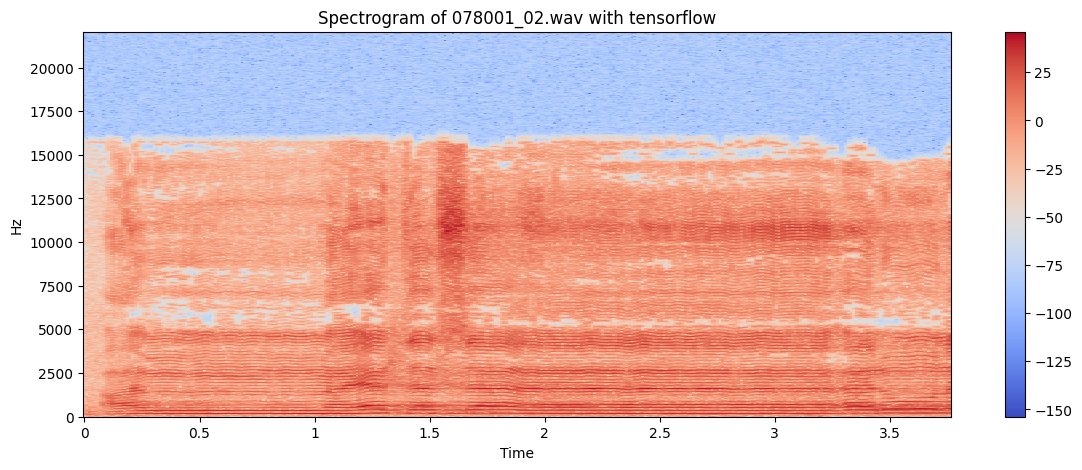

In [19]:
index = 1
spec_lb = get_spectrogram_lb(lb_audios[index], 2048, 512)
plot_spectrogram('Spectrogram of ' + files[index]+" with librosa", spec_lb, lb_srs[index])

spec_tf = get_spectrogram_tf(tf_audios[index].numpy(),  2048, 512)
plot_spectrogram('Spectrogram of ' + files[index]+" with tensorflow", spec_tf.numpy(), tf_srs[index].numpy())

print(spec_lb.shape, spec_lb.dtype)
print(spec_tf.shape, spec_tf.dtype)

### Mel Spectogram

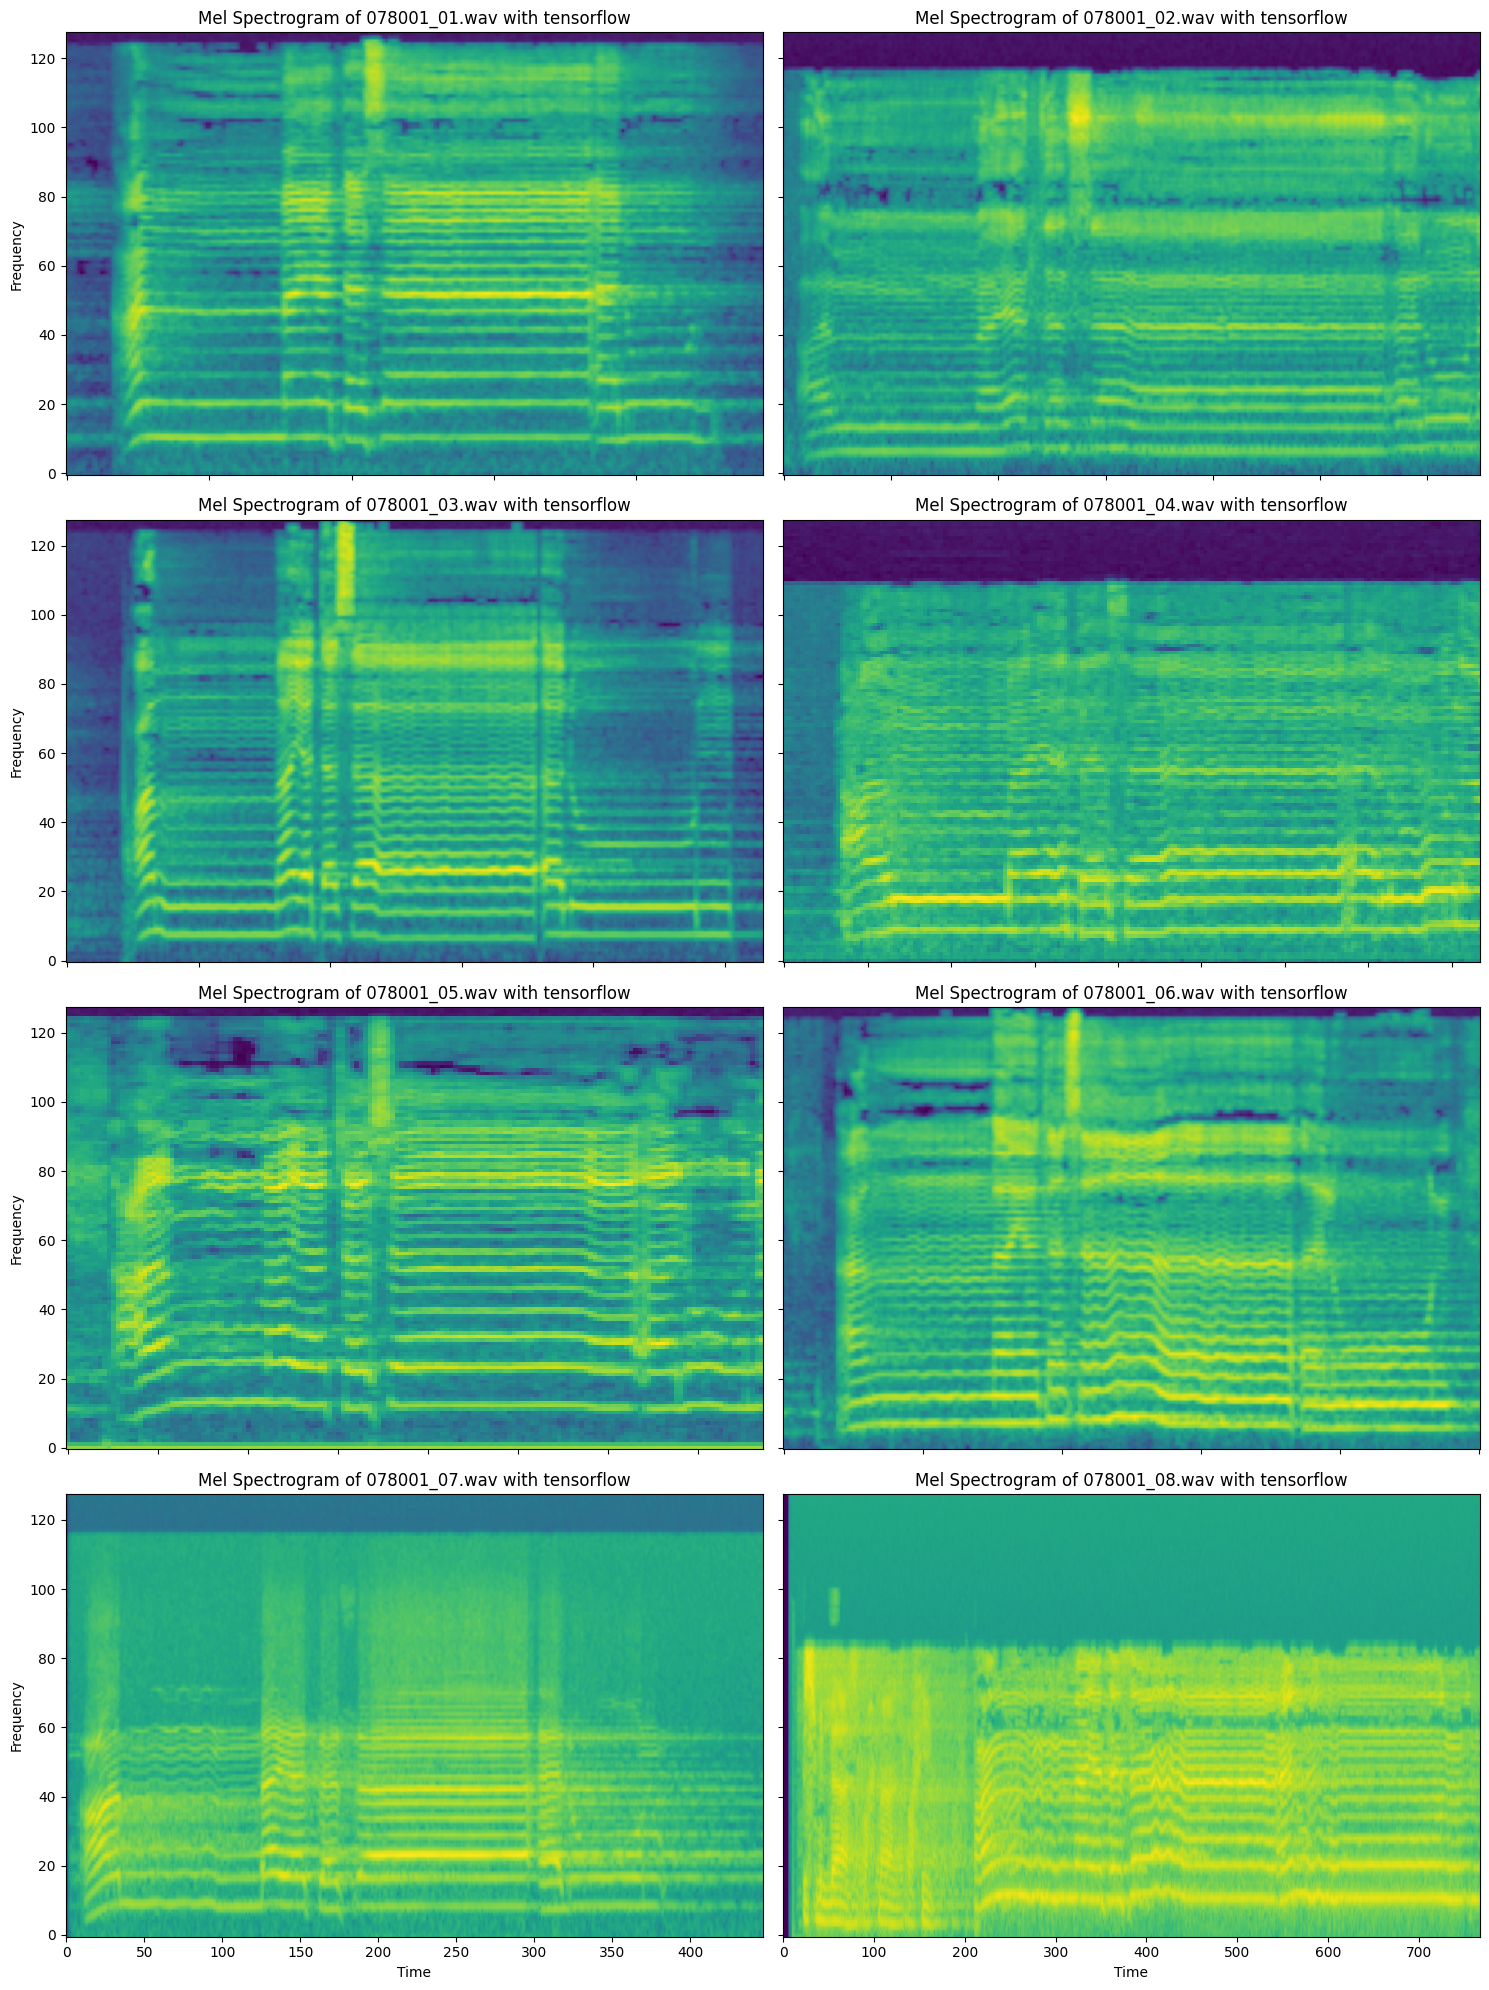

In [20]:
# Parameter
frame_size = 2048
hop_size = 512
n_mel = 128

# Inisialisasi plot
fig, axes = plt.subplots(4, 2, figsize=(15, 20))

# Loop untuk indeks 0 hingga 7
for index in range(8):
    mel_spec_tf = get_mel_spectrogram_tf(tf_audios[index].numpy(), tf_srs[index].numpy(), frame_size, hop_size, n_mel)
    ax = axes[index // 2, index % 2]  # Mendapatkan subplot yang sesuai
    ax.set_title('Mel Spectrogram of ' + files[index] + " with tensorflow")
    ax.imshow(mel_spec_tf.numpy(), aspect='auto', origin='lower')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    ax.label_outer()  # Hide x labels and tick labels for top plots and y ticks for right plots

# Menampilkan plot
plt.tight_layout()
plt.show()

jumlah sample audio librosa 197592
jumlah sample audio tensorflow 395183
frekuensi bins 1025
frames librosa 382
frames tensorflow 768
(128, 382) (128, 768)


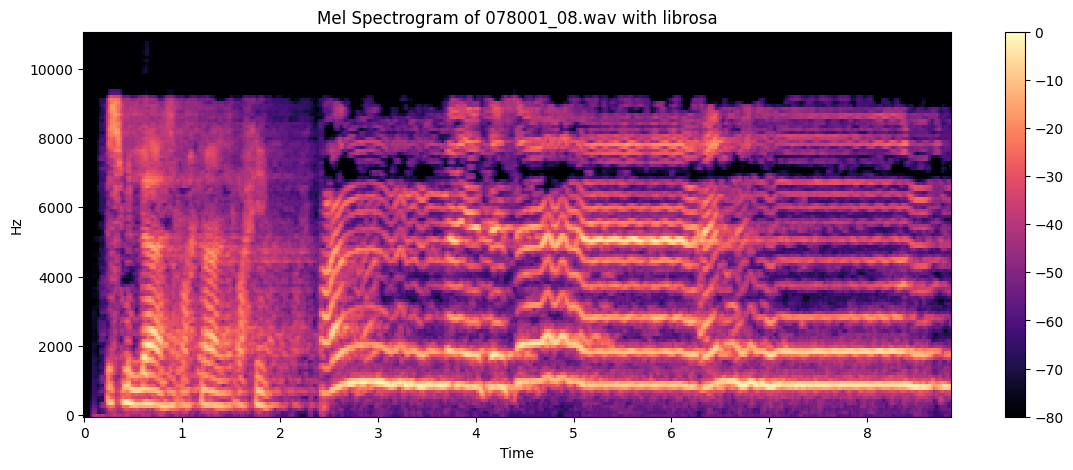

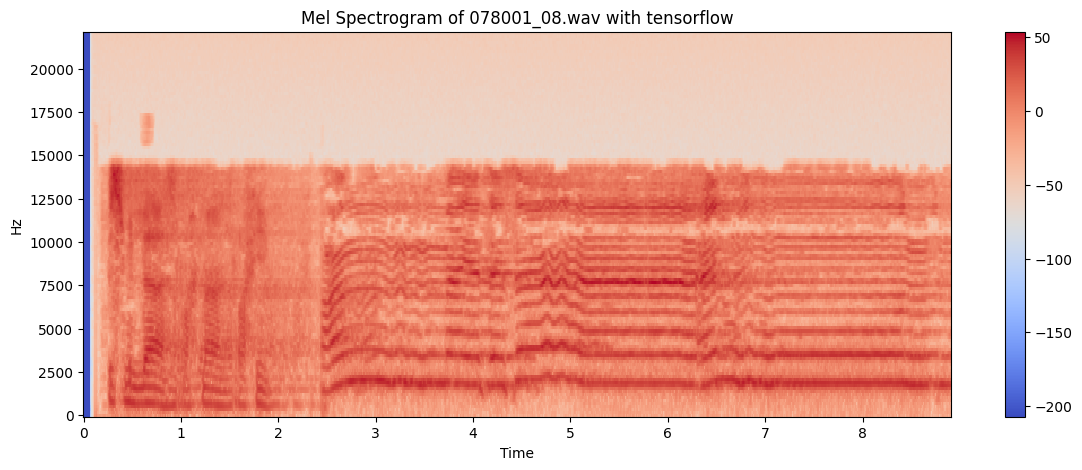

In [24]:
index = 7

frame_size = 2048
hop_size = 512
n_mel = 128

mel_spec_lb = get_mel_spectrogram_lb(lb_audios[index], lb_srs[index], frame_size, hop_size, n_mel)
plot_spectrogram('Mel Spectrogram of ' +files[index]+" with librosa", mel_spec_lb, lb_srs[index])

mel_spec_tf = get_mel_spectrogram_tf(tf_audios[index].numpy(), tf_srs[index].numpy(), frame_size, hop_size, n_mel)
plot_spectrogram('Mel Spectrogram of ' + files[index]+" with tensorflow", mel_spec_tf.numpy(), tf_srs[index].numpy())

print("jumlah sample audio librosa", lb_audios[index].shape[0])
print("jumlah sample audio tensorflow", tf_audios[index].shape[0])
print("frekuensi bins", frame_size // 2 + 1)
print("frames librosa", (lb_audios[index].shape[0] - frame_size) // hop_size + 1)
print("frames tensorflow", (tf_audios[index].shape[0] - frame_size) // hop_size + 1)

print(mel_spec_lb.shape, mel_spec_tf.shape)